<a href="https://colab.research.google.com/github/Shegy12/GAN-for-generating-artificial-ECG-data/blob/master/GANy2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**SYNTHESIS OF REALISTIC ECG USING GENERATIVE ADVERSARIAL NETWORKS**
* https://arxiv.org/abs/1909.09150

# **Install python packages**

In [0]:
!pip3 install scipy keras
#!pip install mat73

# **Imports**

In [0]:
# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import sys
import os
import datetime
from enum import Enum
from pathlib import Path

# numpy
import numpy as np
from numpy import zeros
from numpy import ones
from numpy import hstack
from numpy.random import rand
from numpy.random import randn

# Basics of Python data handling and visualization

import matplotlib.pyplot as plt
from matplotlib import pyplot
import scipy.io as sio
from timeit import default_timer as timer
import matplotlib as mpl

#keras
from keras.models import Sequential
from keras.layers import Conv1D, TimeDistributed, MaxPooling1D, Dense, Softmax, Flatten, LeakyReLU, Activation, BatchNormalization, Dropout, LSTM, Bidirectional, Reshape
from keras.activations import relu
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.initializers import RandomNormal
from keras.layers import ZeroPadding1D

#preprocessing
import random
from sklearn import preprocessing
import scipy.stats
from scipy.signal import resample

Using TensorFlow backend.


# **Google drive**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

GOOGLE_DRIVE_PATH = Path('/content/gdrive/My Drive')
WORKDIR = 'ECG_DATA' # specify the path to folder which you are intend to work with in this notebook
WORKDIR_PATH = GOOGLE_DRIVE_PATH / WORKDIR

if not os.path.exists(WORKDIR_PATH):
          os.mkdir(WORKDIR_PATH)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# **Paths**

In [0]:
#ANNOTATION - nazvy a anotacie/labely
ANNOTATION_PATH = WORKDIR_PATH / "annotFull.mat"
#MATDATA - signal database (.mat)
SINUS_PATH = WORKDIR_PATH / "SINUS"
AF_SV_VR_PATH = WORKDIR_PATH / "AF_SV_VR"
AB_AV_BB_PV_PATH = WORKDIR_PATH / "AB_AV_BB_PV"
OTHER_NOISY_PATH = WORKDIR_PATH / "OTHER_NOISY"

### Parameters

In [0]:
# which signals to load

#subor= "SI2_II.npy"    # start signaly
#subor="SI2_II_end.npy"  # end signaly
subor="SI2_II_full.npy"      #full signaly
fvz=125 #500
clip_value_top=2000
clip_value_bottom=1500
clip_value_top2=1200
clip_value_bottom2=1200

## Preprocessing the input data
* Delete signals that does not fall into range [2000 , -1000]
* Clip them to range [1200, 540] - easily normalized after
* Normalize inputs to the range [-1, 1] and use tanh in the generator output.

In [0]:
SI2_II=np.load(WORKDIR_PATH / subor)
SI2_II=np.transpose(SI2_II)
SI2_II=SI2_II.astype('float32')


print('Data type of SI2 ->          ' + str(SI2_II.dtype))
print('Type of SI2 ->               ' + str(type(SI2_II)))
print('Shape of SI2 ->              ' + str(np.shape(SI2_II)))

resampled_signals_60=[]
for i in range(SI2_II.shape[1]):
	resampled_signals_60.append(scipy.signal.resample(SI2_II[:,i],600))
resampled_signals_60=np.asarray(resampled_signals_60)
resampled_signals_60=np.transpose(resampled_signals_60)
print('Signal resampled from 500Hz to 60Hz ->              ' + str(np.shape(resampled_signals_60)))

SI2_II=resampled_signals_60

# SI2_II=resampled_signals_360[479:3599,:]
# print('Signal shortened from 3600 to 3120 samples ->              ' + str(np.shape(SI2_II)))

number_of_signals = SI2_II.shape[1]
length_of_signal = SI2_II.shape[0]

print('Clip value top of SI2 ->         ' + str(clip_value_top) + 'μV')
print('Clip value bottom of SI2 ->      ' + str(clip_value_bottom) + 'μV')

idx=[]
for i in range (number_of_signals):
  for j in range(length_of_signal):
    if SI2_II[j,i] > clip_value_top:
      #SI2_II[j,i]= clip_value
      idx.append(i)
    elif SI2_II[j,i] < (-clip_value_bottom):
      #SI2_II[j,i]= -clip_value
      idx.append(i)

# start of signals ERROR detection
# idx=[]
# for i in range (number_of_signals):
#   for j in range(50):
#     if SI2_II[j,i] > 500:
#       #SI2_II[j,i]= clip_value
#       idx.append(i)
#     elif SI2_II[j,i] < -500:
#       #SI2_II[j,i]= (-clip_value)
#       idx.append(i)


clipped_signals_idx=np.unique(idx)
print('Number of clipped signals -> ' + str(len(clipped_signals_idx)))

# time_axis=np.linspace(0,length_of_signal/500,length_of_signal)
# #Signals visualization 
# for j in clipped_signals_idx:
#   plt.figure(figsize=(6,3))
#   plt.plot(time_axis, (SI2_II[:,j]))
#   pyplot.title(labels_names[1])
#   #pyplot.xlabel('Time [s]')
#   pyplot.ylabel('Amplitude [μV]')

SI2_II=np.delete(SI2_II,clipped_signals_idx[:],1)
print('These signals were deleted.')

number_of_signals = SI2_II.shape[1]
length_of_signal = SI2_II.shape[0]
time_axis=np.linspace(0,600/60,600)

print('Clip value top of SI2 ->         ' + str(clip_value_top2) + 'μV')
print('Clip value bottom of SI2 ->      ' + str(clip_value_bottom2) + 'μV')

idx=[]
for i in range (number_of_signals):
  for j in range(length_of_signal):
    if SI2_II[j,i] > clip_value_top2:
      SI2_II[j,i]= clip_value_top2
      #idx.append(i)
    elif SI2_II[j,i] < (-clip_value_bottom2):
      SI2_II[j,i]= -clip_value_bottom2
      #idx.append(i)

print('Number of SI2 signals ->     ' + str(number_of_signals))
print('Length of SI2 signals ->     ' + str(length_of_signal))
print('Time axis :')
print(time_axis)
print('Time axis length is :' + str(len(time_axis)))
print('Max of SI_II_11 :' + str(np.amax(SI2_II)))
print('Min of SI_II_11 :' + str(np.amin(SI2_II)))


# normalize to 0-1 each series independently
SI2_II_01=[]
for i in range(SI2_II.shape[1]):
  SI2_II_01.append((SI2_II[:,i] - np.amin(SI2_II[:,i])) / (np.amax(SI2_II[:,i]) - np.amin(SI2_II[:,i])))
SI2_II_01=np.asarray(SI2_II_01)
SI2_II_01=np.reshape(SI2_II_01,(SI2_II.shape[0],SI2_II.shape[1]))

SI2_II_11=(SI2_II)/clip_value_top2 #1200

print('Shape of 01 normalization ->              ' + str(np.shape(SI2_II_01)))
print('Range of 01 normalization ->          ' + '[' + str(np.amin(SI2_II_01)) + ',' + str(np.amax(SI2_II_01))+ ']' )
print('Shape of 11 normalization ->              ' + str(np.shape(SI2_II_11)))
print('Range of 11 normalization ->          ' + '[' + str(np.amin(SI2_II_11)) + ',' + str(np.amax(SI2_II_11))+ ']' )  

# noisy01
noisy_signals_01=[]
pure = np.linspace(-1, 1, SI2_II.shape[0])
noise = np.random.normal(0, 0.1, pure.shape)
for i in range(SI2_II.shape[1]):
	noisy_signals_01.append(SI2_II_01[:,i] + noise)
noisy_signals_01=np.asarray(noisy_signals_01)
noisy_signals_01=noisy_signals_01.reshape(SI2_II.shape[0],SI2_II.shape[1])

print('Range of noisy signals01 ->          ' + '[' + str(np.amin(noisy_signals_01)) + ',' + str(np.amax(noisy_signals_01))+ ']' )  
print('Shape of noisy_signals01 ->              ' + str(np.shape(noisy_signals_01)))

# noisy11

noisy_signals_11=[]
pure = np.linspace(-1, 1, SI2_II.shape[0])
noise = np.random.normal(0, 0.1, pure.shape)
for i in range(SI2_II.shape[1]):
	noisy_signals_11.append(SI2_II_11[:,i] + noise)
noisy_signals_11=np.asarray(noisy_signals_11)
noisy_signals_11=noisy_signals_11.reshape(SI2_II.shape[0],SI2_II.shape[1])

print('Range of noisy signals11 ->          ' + '[' + str(np.amin(noisy_signals_11)) + ',' + str(np.amax(noisy_signals_11))+ ']' )  
print('Shape of noisy_signals11 ->              ' + str(np.shape(noisy_signals_11)))

#**PEAKS DETECTION**

In [0]:
SI2_II_01_1=SI2_II_01[38:225,:]
SI2_II_01_2=SI2_II_01[225:412,:]
SI2_II_01_3=SI2_II_01[412:599,:]

print('Shape of SI2_II_01_1 ->              ' + str(np.shape(SI2_II_01_1)))
print('Shape of SI2_II_01_1 ->              ' + str(np.shape(SI2_II_01_2)))
print('Shape of SI2_II_01_1 ->              ' + str(np.shape(SI2_II_01_3)))

SI2_II_01=np.stack((SI2_II_01_1, SI2_II_01_2,SI2_II_01_3),axis=-1)
SI2_II_01=np.reshape(SI2_II_01,(187,3232*3))
np.shape(SI2_II_01)

(187, 9696)

# **Discriminator CNN**

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 185, 3)            12        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 183, 3)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 181, 5)            50        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 90, 5)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 44, 8)             128       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 21, 8)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 9, 12)            

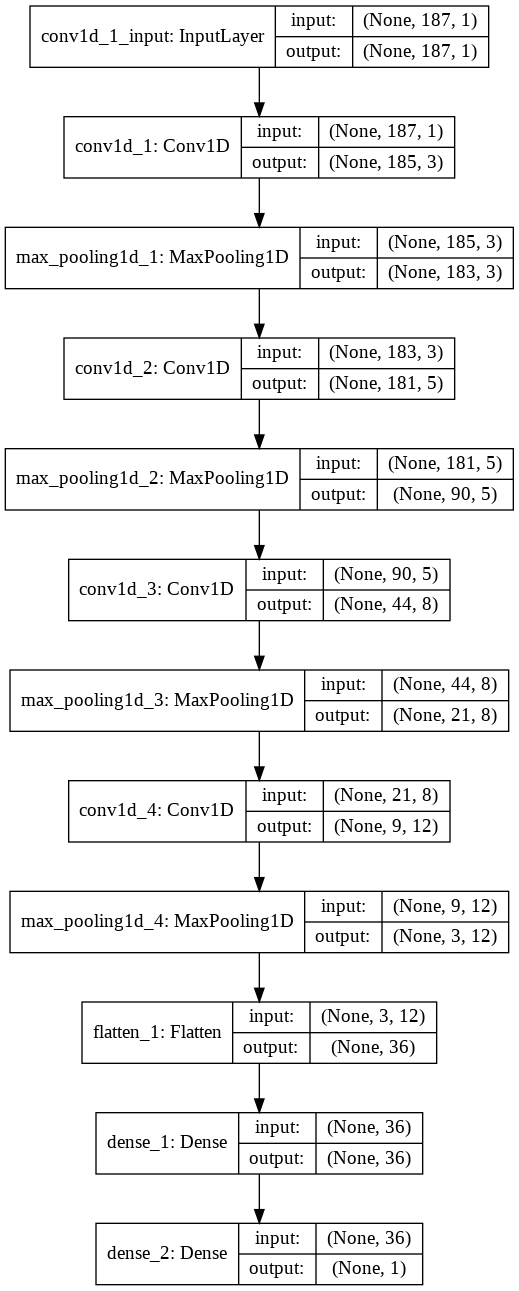

In [0]:
def define_discriminator_CNN(input_shape=(3120,1)):
  model = Sequential()
  #C1
  model.add(Conv1D(input_shape=(187,1),filters=3, kernel_size=3, strides=1, padding='valid',activation='relu'))
  # model.add(Conv1D(input_shape=(187,1),filters=3, kernel_size=3, strides=1, padding='valid', data_format='channels_last', dilation_rate=1, 
  #                  activation='relu', use_bias=True, kernel_initializer='he_normal', bias_initializer='zeros', kernel_regularizer=None, 
  #                  bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None))
  # P = 1
  # model.add(ZeroPadding1D(padding=P))
  #model.add(LeakyReLU(alpha=0.2))

  #P1
  model.add(MaxPooling1D(pool_size=3, strides=1, padding='valid', data_format='channels_last'))

  #C2
  model.add(Conv1D(filters=5, kernel_size=3, strides=1, padding='valid',activation='relu'))
  # model.add(Conv1D(filters=5, kernel_size=5, strides=1, padding='valid', data_format='channels_last', dilation_rate=1, 
  #                  activation='relu', use_bias=True, kernel_initializer='he_normal', bias_initializer='zeros', 
  #                  kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None))
  #P = 2
  #model.add(ZeroPadding1D(padding=P))
  #model.add(LeakyReLU(alpha=0.2))

  #P2
  model.add(MaxPooling1D(pool_size=3, strides=2, padding='valid', data_format='channels_last'))
  #model.add(Conv1D(filters=5, kernel_size=36, strides=3, padding='valid'))

  #C3
  model.add(Conv1D(filters=8, kernel_size=3, strides=2, padding='valid',activation='relu'))
  # model.add(Conv1D(filters=8, kernel_size=3, strides=2, padding='valid', data_format='channels_last', dilation_rate=1, 
  #                  activation='relu', use_bias=True, kernel_initializer='he_normal', bias_initializer='zeros', 
  #                  kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None))
  #P = 3
  #model.add(ZeroPadding1D(padding=P))
  
  #model.add(LeakyReLU(alpha=0.2))

  #P3
  model.add(MaxPooling1D(pool_size=3, strides=2, padding='valid', data_format='channels_last'))

  #C4
  model.add(Conv1D(filters=12, kernel_size=5, strides=2, padding='valid',activation='relu'))
  # model.add(Conv1D(filters=12, kernel_size=5, strides=2, padding='valid', data_format='channels_last', dilation_rate=1, 
  #                  activation='relu', use_bias=True, kernel_initializer='he_normal', bias_initializer='zeros', 
  #                  kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None))
  #P = 5
  #model.add(ZeroPadding1D(padding=P))
  
  #model.add(LeakyReLU(alpha=0.2))
  #P4
  model.add(MaxPooling1D(pool_size=5, strides=2, padding='valid', data_format='channels_last'))
  model.add(Flatten())
  model.add(Dense(36))
  model.add(Dense(1, activation='sigmoid'))
  #sgd_D = SGD(lr=0.00001)
  adam_D = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=adam_D, metrics=['accuracy'])
  return model

# define the discriminator model
discriminator_model = define_discriminator_CNN()
# summarize the model
discriminator_model.summary()
# plot the model
plot_model(discriminator_model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

#NOTES:

# BCEWithLogitsLoss() and Sigmoid() doesn't work together, because BCEWithLogitsLoss() includes the Sigmoid activation. 
# So you can use BCEWithLogitsLoss() without Sigmoid() or you can use Sigmoid() and BCELoss()
#1. Use Strided Convolutions - done
#2. Use Batch Normalization - bad results

# Batch normalization standardizes the activations from a prior layer to have a zero mean and unit variance. This has the effect of stabilizing the training process.
# Batch normalization is used after the activation of convolution and transpose convolutional layers in the discriminator and generator models respectively.
# It is added to the model after the hidden layer, but before the activation, such as LeakyReLU.

# OPTIMALIZATION OPTIONS:

# 0 inicializacia
# 1 padding
# 2 umiestnenie flatten vrstvy
# 3 Use label smoothing in the discriminator, with small random noise.  
# 4 Add random noise to the labels in the discriminator.
# 5 Add noise to inputs to the discriminator and decay the noise over time.
# 6 Optimalizer / paper= SGD a mini-batch o dlzke 100/ adam je v GANoch standart
#   sgd = SGD(lr=0.00001) + maybe? -> decay=1e-6, momentum=0.9, nesterov=True
#   adam = Adam(lr=0.0002, beta_1=0.5)
# 7 Remove Fully-Connected Layers
# 8 Use ReLU, Leaky ReLU, and Tanh
# 9 The best practice for DCAGAN models reported in the paper is to initialize all weights using a zero-centered Gaussian distribution (the normal or bell-shaped distribution) with a standard deviation of 0.02.
#   tried with tf.random.normal didnt work
# 10 Kernel size, filters, strides

# **Discriminator LSTM (not used)**

In [0]:
# def define_discriminator_LSTM():
#   model = Sequential()
#   model.add(LSTM(50, return_sequences=True,input_shape=(187,latent_dim)))
#   #model.add(LeakyReLU(alpha=0.2))
#   model.add(LSTM(50, return_sequences=True))
#   model.add(MinibatchDiscrimination(5, 3))
#   #model.add(LeakyReLU(alpha=0.2))
#   # model.add(Dropout(0.5, noise_shape=None, seed=None))
#   model.add(Dense(1, activation='sigmoid'))
#   return model

# **Generator BiLSTM**

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 187, 50)           22400     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 187, 50)           40400     
_________________________________________________________________
dense_3 (Dense)              (None, 187, 1)            51        
Total params: 62,851
Trainable params: 62,851
Non-trainable params: 0
_________________________________________________________________


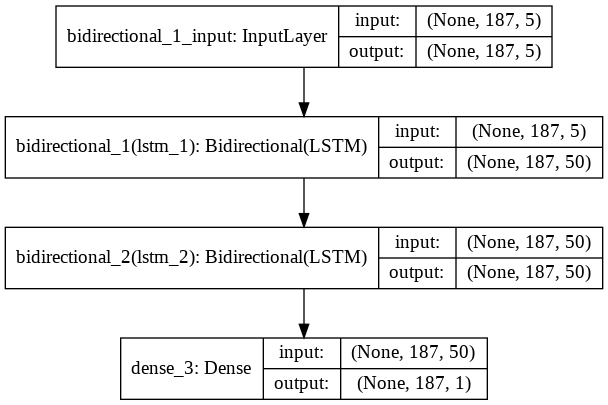

In [0]:
def define_generator_BiLSTM(latent_dim):
  model = Sequential()
  model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(187,latent_dim), merge_mode='sum'))
  #model.add(LeakyReLU(alpha=0.2))
  model.add(Bidirectional(LSTM(50, return_sequences=True),merge_mode='sum'))
  #model.add(LeakyReLU(alpha=0.2))
  # model.add(Dropout(0.5, noise_shape=None, seed=None))
  # The output layer is a two-dimensional vector where the first element represents the time step and the second element denotes the lead.
  model.add(Dense(1))
  #model.add(Dense(1, activation='tanh'))

  return model

  # model.add(Bidirectional(LSTM(100, activation='tanh', recurrent_activation='tanh', use_bias=True, kernel_initializer='random_normal', 
  # recurrent_initializer='zeros', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, 
  # bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, 
  # recurrent_dropout=0.0, implementation=2, return_sequences=True, 
  # return_state=False, go_backwards=False, stateful=False, unroll=False),input_shape=(3120,latent_dim), merge_mode='sum'))
  # return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.

  #model.add(Bidirectional(LSTM(100, activation='tanh', recurrent_activation='tanh', use_bias=True, kernel_initializer='random_normal', 
  #recurrent_initializer='zeros', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, 
  #bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, 
  #recurrent_dropout=0.0, implementation=2, return_sequences=True, 
  #return_state=False, go_backwards=False, stateful=False, unroll=False),merge_mode='sum'))


# size of the latent space
latent_dim =5
# define the generator model
generator_model = define_generator_BiLSTM(latent_dim)
# summarize the model
generator_model.summary()
# plot the model
plot_model(generator_model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)


# NOTES:

# 1 Return sequences - TRUE
# 2 Use dropout of 50 percent during train and generation. - ALREADY USING
# 3 Normalize inputs to the range [-1, 1] and use tanh in the generator output. - DONE
# 4 Recurrent_activation: Activation function to use for the recurrent step (see activations). Default: hard sigmoid (hard_sigmoid). 
#   If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).
# 5 LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. 
#   It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. ” alebo [-1,1] ak mam tanh

# OPTIMALIZATION OPTIONS:

# 1 Use Leaky ReLU in the generator and discriminator.
# 2 The best practice for DCAGAN models reported in the paper is to initialize all weights using 
#   a zero-centered Gaussian distribution (the normal or bell-shaped distribution) with a standard deviation of 0.02.

# **Generator LSTM**

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 187, 50)           11200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 187, 50)           20200     
_________________________________________________________________
dense_47 (Dense)             (None, 187, 50)           2550      
Total params: 33,950
Trainable params: 33,950
Non-trainable params: 0
_________________________________________________________________


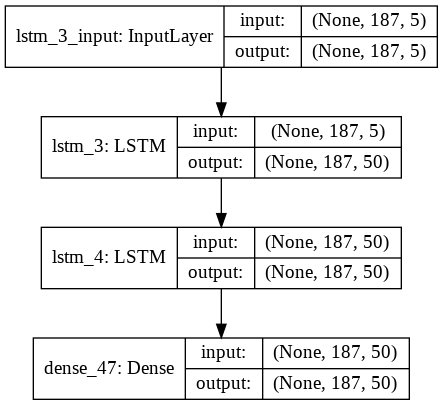

In [0]:
def define_generator_LSTM(latent_dim):
  model = Sequential()
  model.add(LSTM(50, return_sequences=True,input_shape=(187,latent_dim)))
  #model.add(LeakyReLU(alpha=0.2))
  model.add(LSTM(50, return_sequences=True))
  #model.add(LeakyReLU(alpha=0.2))
  # model.add(Dropout(0.5, noise_shape=None, seed=None))
  # The output layer is a two-dimensional vector where the first element represents the time step and the second element denotes the lead.
  model.add(Dense(1))
  return model

# size of the latent space
latent_dim =5
# define the generator model
generator_model = define_generator_LSTM(latent_dim)
# summarize the model
generator_model.summary()
# plot the model
plot_model(generator_model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)


# NOTES:

# 1 Return sequences - TRUE
# 2 Use dropout of 50 percent during train and generation. - ALREADY USING
# 3 Normalize inputs to the range [-1, 1] and use tanh in the generator output. - DONE
# 4 Recurrent_activation: Activation function to use for the recurrent step (see activations). Default: hard sigmoid (hard_sigmoid). 
#   If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).
# 5 LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. 
#   It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. ” alebo [-1,1] ak mam tanh

# OPTIMALIZATION OPTIONS:

# 1 Use Leaky ReLU in the generator and discriminator.
# 2 The best practice for DCAGAN models reported in the paper is to initialize all weights using 
#   a zero-centered Gaussian distribution (the normal or bell-shaped distribution) with a standard deviation of 0.02.

## Generating fake and real signals

* generator.predict - batch size nechapem?



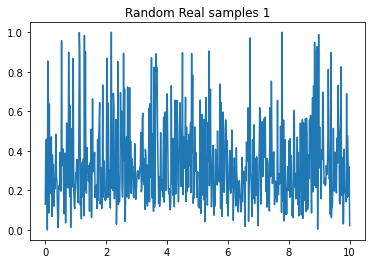

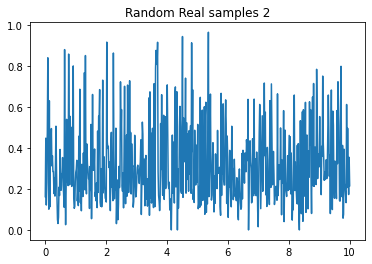

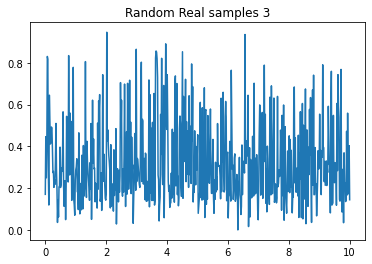

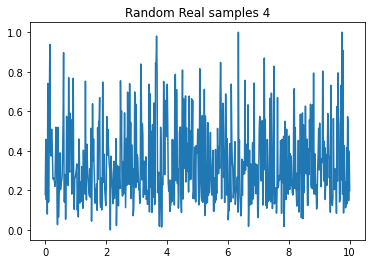

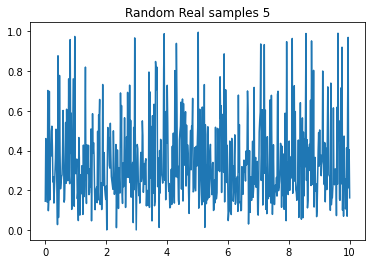

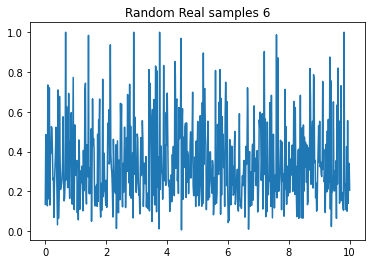

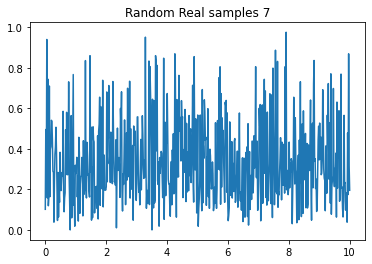

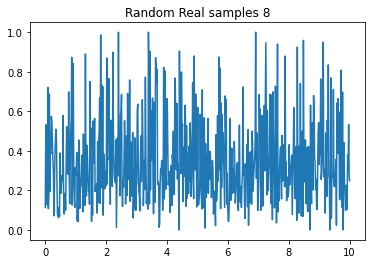

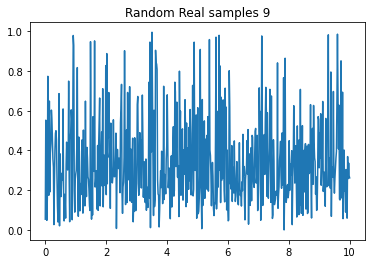

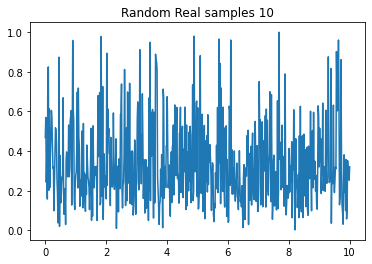

In [0]:
# generate points in latent space as input for the generator
def generate_latent_points2(latent_dim,batch_size,mu,sigma):
  #original
  # generate points in the latent space
  #X = np.random.normal(mu,sigma, size=(length_of_signal* latent_dim*batch_size))
  #X=X.reshape(1,length_of_signal,latent_dim) batch x 3120 x 5
  #test2
  #X=X.reshape(length_of_signal,latent_dim) # 3120x5
  #test3
  latent_points= np.random.normal(mu,sigma, size=(batch_size* latent_dim))
  latent_points=latent_points.reshape(batch_size,latent_dim) #batch x 5
  return latent_points

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim,batch_size,mu,sigma):
  # generate points in the latent space
  latent_points = np.random.normal(mu,sigma, size=(187 * latent_dim * batch_size))
  latent_points=latent_points.reshape(batch_size,187,latent_dim) #batch x 3120 x 5
  return latent_points


# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, batch_size,mu,sigma):
  # generate points in latent space
  label=[]
  X = generate_latent_points(latent_dim, batch_size,mu,sigma)
  # predict outputs
  x_input = generator_model.predict(X)
  # create class labels - LABEL SMOOTHING
  for i in range(batch_size):
    y = np.round(random.uniform(0, 0.3),2)
    label.append(y)
  label=np.asarray(label)
  y=label.reshape(batch_size,1)
  #y = np.zeros((batch_size,1))
  return x_input,y

def generate_real_samples(batch_size,signal):
  label=[]
  X=[]
  cisla=[]
  for i in range (batch_size):
    cislo_signalu=random.randint(0, signal.shape[1]-1)
    X.append(signal[:,cislo_signalu])
    #randomness control - if it generates random numbers everytime
    #cisla.append(cislo_signalu)
  X=np.asarray(X)
  X=X.reshape(batch_size,187,1)
  for i in range(batch_size):
    y = np.round(random.uniform(0.7, 1),2)
    label.append(y)
  label=np.asarray(label)
  y=label.reshape(batch_size,1)
  #y = np.ones((batch_size,1))
  return X,y #cisla

# signal statistics for gaussian distributions

SI2_II_11_mean=np.mean(np.mean(SI2_II_11, axis=0))
SI2_II_11_std=np.std(SI2_II_11)
SI2_II_01_mean=np.mean(np.mean(SI2_II_01, axis=0))
SI2_II_01_std=np.std(SI2_II_01)


print('Mean of SI2_II_11_mean :')
print(SI2_II_11_mean)
print('Std of SI2_II_11_mean :')
print(SI2_II_11_std)
print('Mean of SI2_II_01_mean :')
print(SI2_II_01_mean)
print('Std of SI2_II_01_mean :')
print(SI2_II_01_std)    

latent_points=generate_latent_points(latent_dim=5,batch_size=5,mu=SI2_II_01_mean,sigma=SI2_II_01_std)
print('Latent space points shape:')
print(np.shape(latent_points))
print('Latent space 5 dimensions, 187 samples : ')
print(latent_points)

#plot latent points
for i in range(5): 
  count, bins, ignored = plt.hist(latent_points[i][:,0], 30, density=True)
  plt.plot(bins, 1/(SI2_II_01_std * np.sqrt(2 * np.pi))*np.exp( - (bins - SI2_II_01_mean)**2 / (2 * SI2_II_01_std**2) ), linewidth=2, color='r')
  pyplot.title('Latent points samples'+ ' '+ str(i+1))
  plt.show()

# generate fake samples
fake_data,y = generate_fake_samples(generator_model, latent_dim=5,batch_size=5, mu=SI2_II_01_mean, sigma=SI2_II_01_std)

print('Fake data points shape:')
print(np.shape(fake_data))
print('Fake data  points [0]:')
print(fake_data[i][:,0])


for i in range(5): 
  count, bins, ignored = plt.hist(fake_data[i][:,0], 30, density=True)
  plt.plot(bins, 1/(SI2_II_01_std * np.sqrt(2 * np.pi))*np.exp( - (bins - SI2_II_01_mean)**2 / (2 * SI2_II_01_std**2) ), linewidth=2, color='r')
  pyplot.title('Random Fake samples'+ ' '+ str(i+1))
  plt.show()

for i in range(5): 
  # plot samples
  plt.plot(time_axis, fake_data[i][:,0])
  pyplot.title('Random Fake samples'+ ' '+ str(i+1)) 
  pyplot.show()

np.shape(time_axis)
# generate samples
real_data,y = generate_real_samples(5,SI2_II_01)

print('Real data points shape:')
print(np.shape(real_data))
print('Real data  points [0]:')
print(real_data[0])
print('Length of Real data  points [0]:')
print(len(real_data[0]))

# plot samples
for i in range(5): 
  plt.plot(time_axis, real_data[i])
  pyplot.title('Random Real samples'+ ' '+ str(i+1)) 
  pyplot.show()

# #noisy
# for i in range(5): 
#   plt.plot(time_axis, noisy_signals_01[:,i])
#   pyplot.title('Noisy signals samples'+ ' '+ str(i+1)) 
#   pyplot.show()

#x_input2=(x_input-noise_min)/(noise_max-noise_min)*(avg_max-avg_min)+avg_min 
#print(np.shape(y2))
#print(np.shape(x_input))
#print(np.shape(x_input2))
#print(np.shape(X))
#print(type(X))
#print(np.shape(X_fake))
#print (np.shape(SI2_II))
#print(np.shape(real_data))
#print(np.shape(fake_data))

#print(np.shape(latent_points))


#**TRAINING**

In [0]:
batch_size=119
#adam
#discriminator trained more